In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import math
import scipy.optimize as sco
import matplotlib.pyplot as plt

In [17]:
observation_period = 5 # number of years for which we get assets' data for portfolio modelling
risky_assets_tickers = ["IIPR", "NVO", "NIO", "VSCO", "KO", "FLO", "ASML", "PM", "MS", "LMT", "JNJ", "LLY", "CHCT"] # list of risky assets whose combination we are going to optimize

In [18]:
assets_data = yf.download(
        risky_assets_tickers,
        start=(datetime.today() - timedelta(days=365*observation_period - 1)).strftime("%Y-%m-%d"),
        end=datetime.today().strftime("%Y-%m-%d")
    )

assets_daily_returns = assets_data["Adj Close"].pct_change().dropna()
expected_annualized_returns = (1 + assets_daily_returns.mean())**252 - 1
covariance_matrix_annualized = assets_daily_returns.cov() * 252

[*********************100%***********************]  13 of 13 completed


In [19]:
expected_annualized_returns

Ticker
ASML    0.108279
CHCT   -0.146347
FLO     0.003558
IIPR   -0.139916
JNJ     0.010259
KO      0.077146
LLY     0.491964
LMT     0.106413
MS      0.193658
NIO    -0.331135
NVO     0.274897
PM      0.170762
VSCO    0.150515
dtype: float64

In [20]:
# Objective Function: Minimize Portfolio Volatility
def portfolio_volatility(weights):
    return np.sqrt(weights.T @ covariance_matrix_annualized @ weights)

def portfolio_return(weights):
    return np.dot(weights, expected_annualized_returns)

Text(0.5, 1.0, 'Possible Portfolios of Risky Assets & Optimal Frontier')

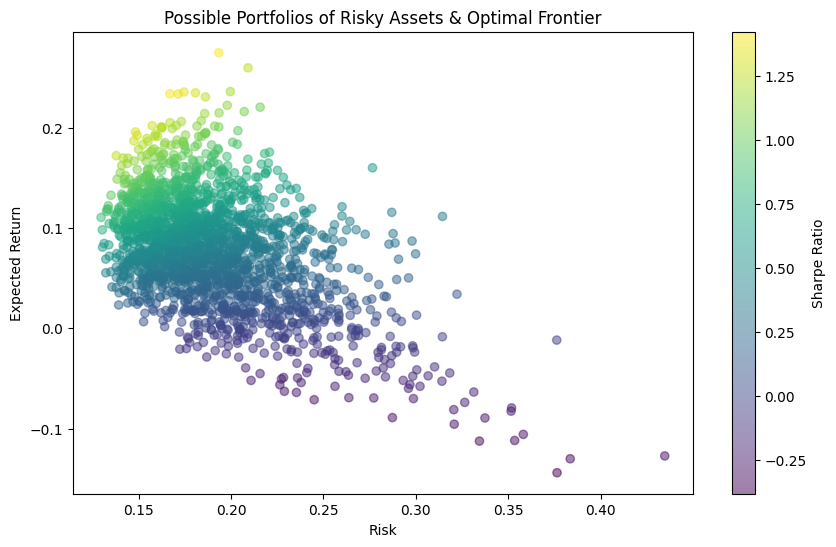

In [24]:
num_portfolios = 2000
random_weights = np.random.dirichlet(np.ones(len(risky_assets_tickers)), num_portfolios)
random_returns = np.array([np.dot(w, expected_annualized_returns) for w in random_weights])
random_volatilities = np.array([portfolio_volatility(w) for w in random_weights])

plt.figure(figsize=(10, 6))
plt.scatter(random_volatilities, random_returns, c=random_returns / random_volatilities, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.title("Possible Portfolios of Risky Assets & Optimal Frontier")


LOOKING FOR THE MOST OPTIMAL PORTFOLIO OF RISKY ASSETS

In [22]:

tested_weights = []
tested_returns = []
tested_volatilities = []
def callback(weights):
    tested_weights.append(weights.copy()) # Weights of assets in portfolio
    tested_returns.append(np.dot(weights, expected_annualized_returns)) # Portfolio Return
    tested_volatilities.append(portfolio_volatility(weights)) # Portfolio Volatility


constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}) # Constraints: Sum of weights = 1
bounds = tuple((0, 1) for _ in range(len(expected_annualized_returns))) # Bounds: Each weight between 0% and 100%
initial_weights = np.ones(len(expected_annualized_returns)) / len(expected_annualized_returns) # Initial Guess (Equal Weights)

# Solve Optimization Problem
optimized_result = sco.minimize(portfolio_volatility, initial_weights,
                                method='SLSQP', bounds=bounds, constraints=constraints, callback=callback,
                                options={'maxiter': 500, 'disp': True, 'ftol': 1e-9})

# Convert stored values to DataFrame for analysis
optimization_log = pd.DataFrame(tested_weights, columns=risky_assets_tickers)
optimization_log["Portfolio Return"] = tested_returns
optimization_log["Portfolio Volatility"] = tested_volatilities

# Extract Optimal Weights
optimal_weights = optimized_result.x
print("Optimal Portfolio Weights:", optimal_weights)
print("Portfolio Volatility:", portfolio_volatility(optimal_weights))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.12071824985411715
            Iterations: 18
            Function evaluations: 252
            Gradient evaluations: 18
Optimal Portfolio Weights: [3.25603175e-02 4.00076438e-02 6.61567442e-02 6.64486582e-18
 2.76256799e-01 2.11114467e-01 1.63771746e-02 1.57774828e-01
 4.00856002e-02 0.00000000e+00 6.97858188e-02 8.98806068e-02
 0.00000000e+00]
Portfolio Volatility: 0.12071824985411715


In [208]:
print(portfolio_volatility(np.array([0.1, 0.15, 0.75])))
print(portfolio_return(np.array([0.1, 0.15, 0.75])))

ValueError: shapes (3,) and (5, 5) not aligned

Text(0.5, 1.0, 'Possible Portfolios of Risky Assets, Optimal Frontier & Tangent Portfolio')

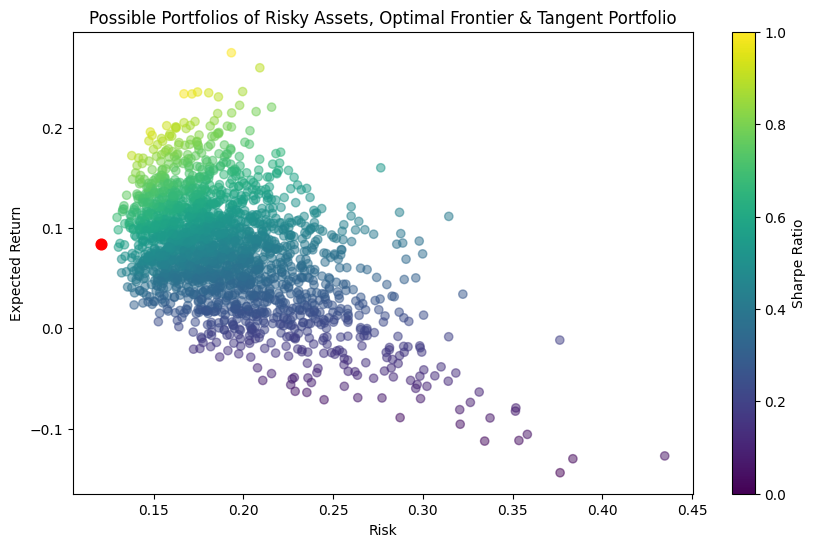

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(random_volatilities, random_returns, c=random_returns / random_volatilities, cmap='viridis', alpha=0.5)
# Tangent Portfolio
plt.scatter(portfolio_volatility(optimal_weights), portfolio_return(optimal_weights), marker="o", color="red", s=60)
# Current Portfolio
#plt.scatter(portfolio_volatility(np.array([0.1, 0.15, 0.75])), portfolio_return(np.array([0.1, 0.15, 0.75])), marker="o", color="red", s=60)
#plt.scatter(portfolio_volatility(np.array([0.1, 0.1, 0.8])), portfolio_return(np.array([0.1, 0.1, 0.8])), marker="o", color="blue", s=60)
#plt.scatter(portfolio_volatility(np.array([0.01, 0.58, 0.419])), portfolio_return(np.array([0.01, 0.58, 0.419])), marker="o", color="green", s=60)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.title("Possible Portfolios of Risky Assets, Optimal Frontier & Tangent Portfolio")

LOOKING FOR THE MOST OPTIMAL PORTFOLIOS FOR DEFINED RISK LEVELS

In [159]:
#target_volatilities = np.linspace(0.1, 0.3, 10)
target_volatilities = [0.18599766904719744]

optimized_portfolios = []

for target_vol in target_volatilities:

    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Constraints: Sum of weights = 1
        {'type': 'eq', 'fun': lambda weights: portfolio_volatility(weights) - target_vol}  # Constraints: Match target volatiltity
    ]
    bounds = tuple((0, 1) for _ in range(len(expected_annualized_returns))) # Bounds: Each weight between 0% and 100%
    initial_weights = np.ones(len(expected_annualized_returns)) / len(expected_annualized_returns) # Initial Guess (Equal Weights)

    # Solve Optimization Problem
    result = sco.minimize(lambda w: -portfolio_return(w), initial_weights, 
                          method='SLSQP', bounds=bounds, constraints=constraints,
                          options={'maxiter': 500, 'disp': True, 'ftol': 1e-9})
    
    if result.success:
        optimized_portfolios.append({
            "Target Volatility": target_vol,
            "Portfolio Volatility": portfolio_volatility(result.x),
            "Portfolio Return": portfolio_return(result.x),
            "Weights": result.x
        })


optimized_df = pd.DataFrame(optimized_portfolios)

optimized_df

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13387497803874324
            Iterations: 9
            Function evaluations: 36
            Gradient evaluations: 9


,Target Volatility,Portfolio Volatility,Portfolio Return,Weights
0,0.185998,0.185998,0.133875,"[0.009903487461032732, 0.4187246833659742, 0.5..."


NameError: name 'optimized_df' is not defined

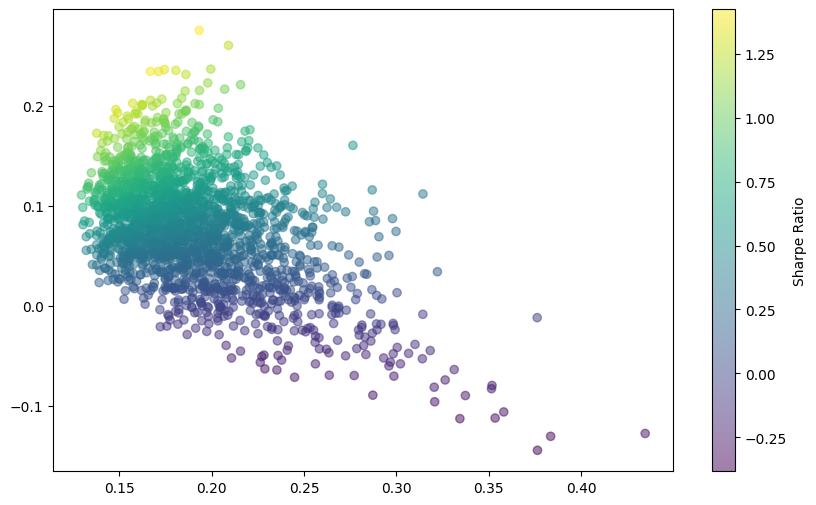

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(random_volatilities, random_returns, c=random_returns / random_volatilities, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(optimized_df["Portfolio Volatility"], optimized_df["Portfolio Return"], 
            color='red', marker='D', label="Optimized Portfolios")